In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

- Broad Question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

- Specific Question: Can played_hours and age predict subscribe in players.csv?

In [9]:
cat("\nNumber of observations in players dataset:", nrow(players))
cat("\nNumber of variables in players dataset:", ncol(players))


Number of observations in players dataset: 196
Number of variables in players dataset: 7

In [67]:
players <- read_csv("https://raw.githubusercontent.com/Jay7615/Project/refs/heads/main/players.csv", show_col_types = FALSE) |>
  select(played_hours, Age, subscribe) |>
  rename(age = Age) |>
   mutate(
    subscribe = factor(subscribe, levels = c(FALSE, TRUE), labels = c("Non-subscriber", "Subscriber")))
subscription_summary <- players |>
  group_by(subscribe) |>
  summarise(
    n = n(),
    percent = n/nrow(players),
    mean_age = mean(age, na.rm = TRUE),
    mean_hours = mean(played_hours),
    median_age = median(age, na.rm = TRUE),
    median_hours = median(played_hours),
    sd_age = sd(age, na.rm = TRUE),
    sd_hours = sd(played_hours),
    na_age = sum(is.na(age)),
    na_hours = sum(is.na(played_hours)),
  ) |>
  mutate(percent = percent(percent, accuracy = 0.1))

players <- players |>
  mutate(age = replace_na(age, median(age, na.rm = TRUE)))
cat("=== Summary ===\n")
print(subscription_summary,, width = Inf)


=== Summary ===
# A tibble: 2 × 11
  subscribe          n percent mean_age mean_hours median_age median_hours
  <fct>          <int> <chr>      <dbl>      <dbl>      <dbl>        <dbl>
1 Non-subscriber    52 26.5%       23.0      0.502         21          0  
2 Subscriber       144 73.5%       19.6      7.78          18          0.1
  sd_age sd_hours na_age na_hours
   <dbl>    <dbl>  <int>    <int>
1   8.17     1.19      0        0
2   5.00    32.9       2        0


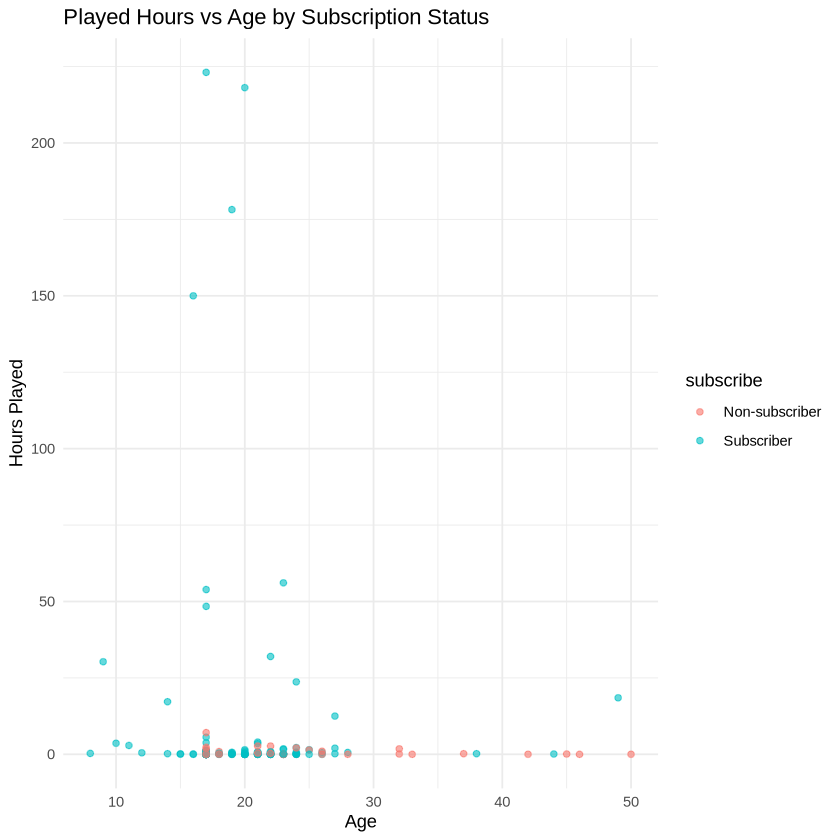

In [71]:
ggplot(players, aes(x = age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.6) +
  labs(title = "Played Hours vs Age by Subscription Status",
       x = "Age", y = "Hours Played") +
  theme_minimal()


In [104]:
set.seed(1000) 
players_split <- initial_split(players, prop = 0.7, strata = subscribe)
training_set <- training(players_split)
testing_set <- testing(players_split)

player_recipe <- recipe(subscribe ~ played_hours + age, 
                    data = training_set) |>
  step_impute_median(age) |>                
  step_normalize(all_numeric_predictors())  

knn_spec <- nearest_neighbor(
  weight_func = "rectangular", 
  neighbors = tune()
) |>
  set_mode("classification") |> 
  set_engine("kknn")
cv_folds <- vfold_cv(training_set, v = 5, repeats = 200, strata = subscribe)
#cv_folds <- vfold_cv(training_set, v = 5, strata = subscribe)

knn_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec)

knn_tune <- knn_workflow |> 
  tune_grid(
    resamples = cv_folds,
    grid = tibble(neighbors = seq(1, 30, by = 1)),
    metrics = metric_set(accuracy, roc_auc)
  )


best_k <- select_best(knn_tune, metric = "accuracy")$neighbors
best_k

[1] 20

In [98]:
final_spec <- nearest_neighbor(
  weight_func = "rectangular",
  neighbors = best_k
) |> 
  set_mode("classification") |>
  set_engine("kknn")

final_fit <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(final_spec) |>
  fit(data = training_set)

player_predictions <- predict(final_fit, new_data = testing_set) |>
  bind_cols(testing_set)

player_results <- player_predictions |>
  rename(predicted_subscription = .pred_class)

player_metrics <- player_results |>
  accuracy(truth = subscribe, estimate = predicted_subscription)

player_conf_mat <- player_results |>
  conf_mat(truth = subscribe, estimate = predicted_subscription)

player_metrics
player_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7333333


                Truth
Prediction       Non-subscriber Subscriber
  Non-subscriber              1          1
  Subscriber                 15         43